In [1]:
import os
from pathlib import Path
print(f"{os.getcwd() = }")

current_dir = Path(os.getcwd())
root_dir = Path(os.getcwd()).parent.parent
models_dir = root_dir.joinpath("models")
plots_dir = current_dir.joinpath("plots_2")

print(f"{root_dir = }")
print(F"{models_dir = }")
print(F"{plots_dir = }")

os.makedirs(plots_dir, exist_ok=True)

os.getcwd() = 'c:\\Users\\Jared\\OneDrive\\Github\\GFlowNets_on_SpinFoams\\notebooks\\Jared_Parameter_Analysis'
root_dir = WindowsPath('c:/Users/Jared/OneDrive/Github/GFlowNets_on_SpinFoams')
models_dir = WindowsPath('c:/Users/Jared/OneDrive/Github/GFlowNets_on_SpinFoams/models')
plots_dir = WindowsPath('c:/Users/Jared/OneDrive/Github/GFlowNets_on_SpinFoams/notebooks/Jared_Parameter_Analysis/plots_2')


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def load_mcmc_intertwiners(mcmc_files):
    intertwiners = []
    for file in mcmc_files:
        df = pd.read_csv(file)
        intertwiners.append(df.loc[df.index.repeat(df.multiplicity)].iloc[:, :-1].to_numpy())
    return np.stack(intertwiners)

def load_gfn_intertwiners(gfn_files):
    return np.stack([pd.read_feather(f).to_numpy() for f in gfn_files])

def calculate_mean_cosine_dihedral_angle(intertwiners, spin):
    cos_angles = intertwiners*(intertwiners+1)/(2*spin*(spin+1)) - 1
    return cos_angles.mean(axis=1)[:, 0]
#     return cos_angles.mean(axis=(1, 2))


def get_empirical_distributions(intertwiners, spin_j):
    _, n_samples, grid_dim = intertwiners.shape
    grid_len = int(2*spin_j + 1)

    empirical_distributions = []
    for inds in intertwiners:
        counts = np.zeros(shape=(grid_len, )*grid_dim)
        np.add.at(counts, tuple(inds.T), 1)
        empirical_distributions.append(counts/n_samples)
        
    return np.stack(empirical_distributions)

def get_l1_distribution_error(intertwiners, spin_j, expected_distribution):
    distributions = get_empirical_distributions(intertwiners, spin_j)
    l1_errors = np.abs(distributions - expected_distribution)
    mean_errors = np.mean(l1_errors, axis=tuple(range(1, l1_errors.ndim)))
    return mean_errors

Running comparison for: model_0
Model number: 1 of 32 



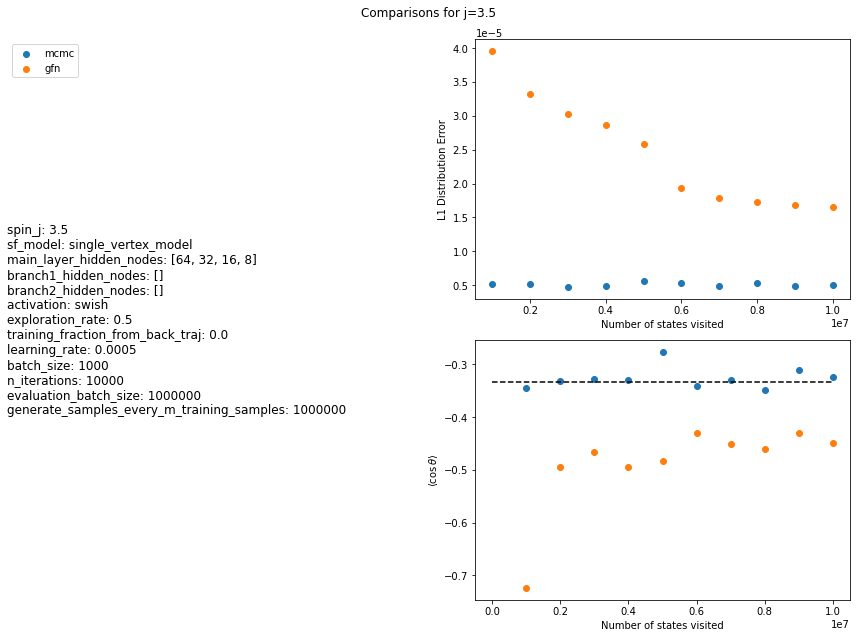

Running comparison for: model_1
Model number: 2 of 32 



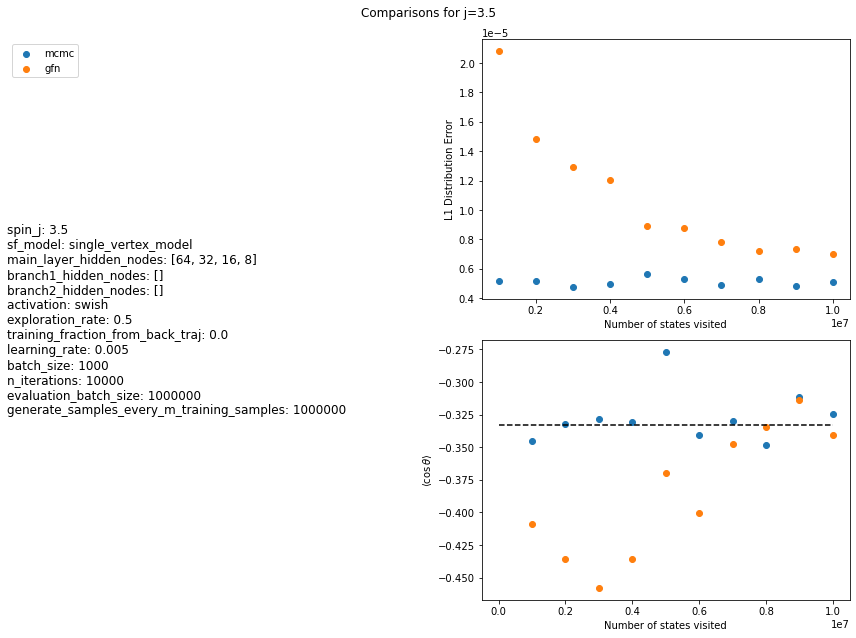

Running comparison for: model_2
Model number: 3 of 32 



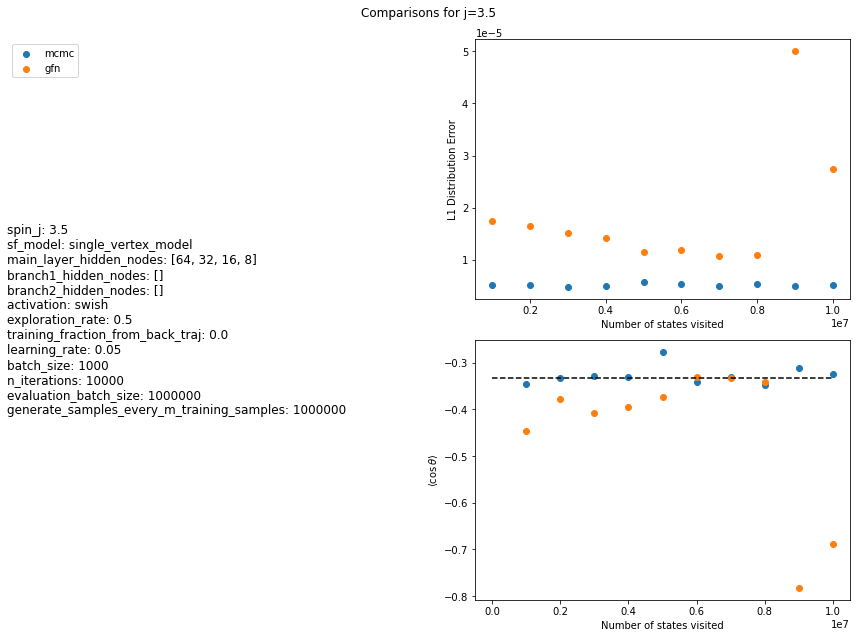

Running comparison for: model_3
Model number: 4 of 32 



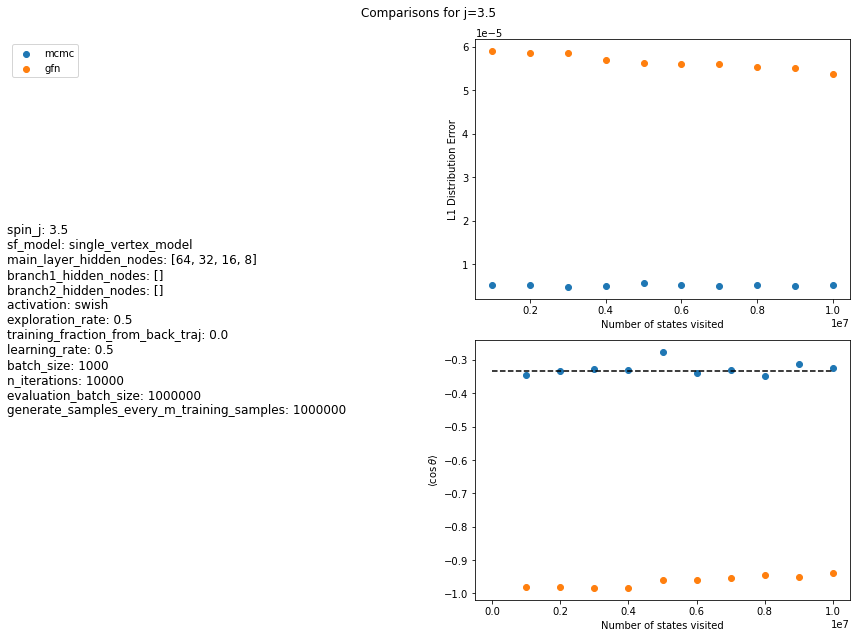

Running comparison for: model_4
Model number: 5 of 32 



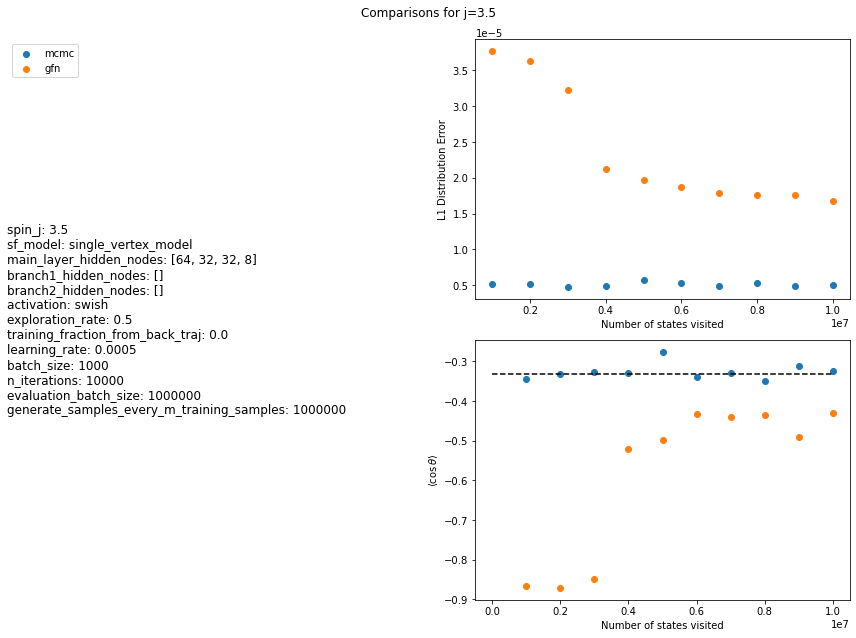

Running comparison for: model_5
Model number: 6 of 32 



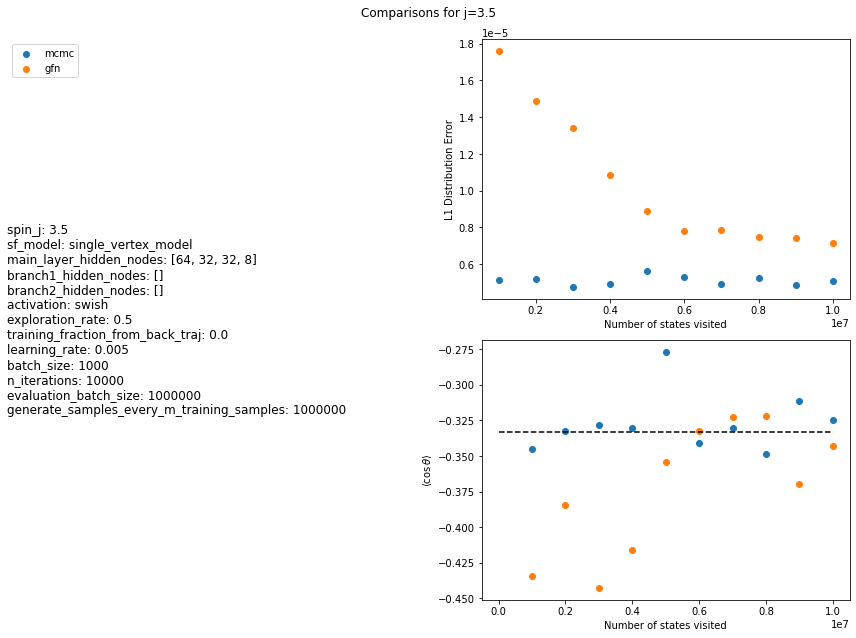

Running comparison for: model_6
Model number: 7 of 32 



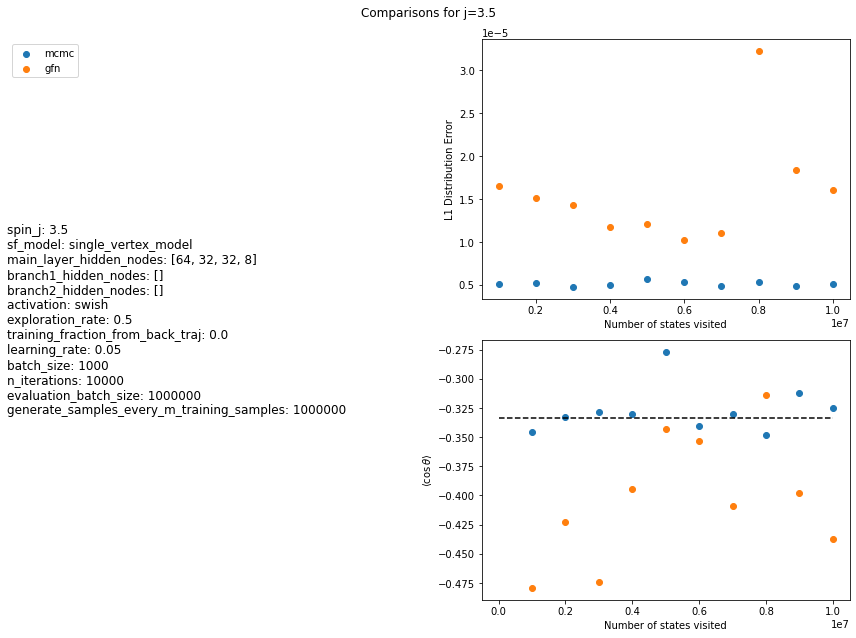

Running comparison for: model_7
Model number: 8 of 32 



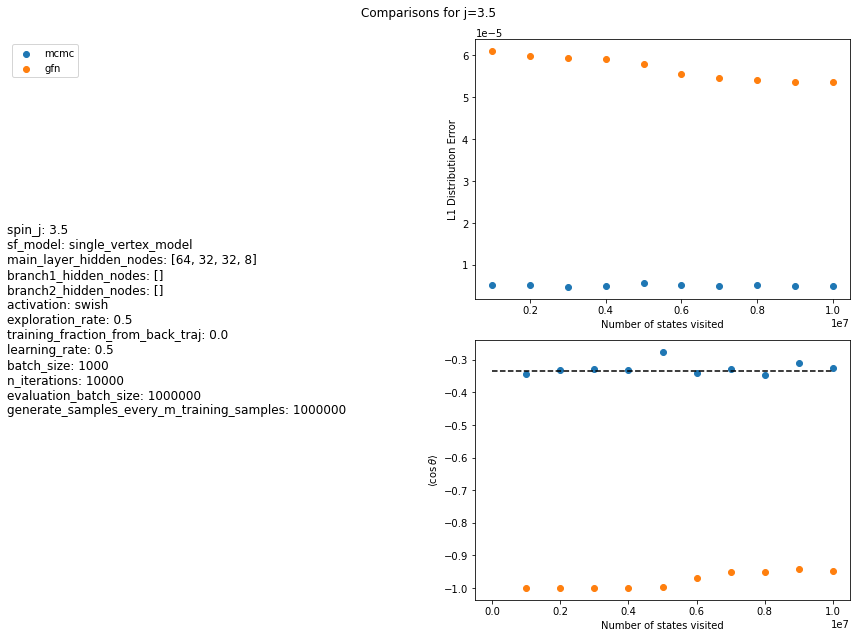

Running comparison for: model_8
Model number: 9 of 32 



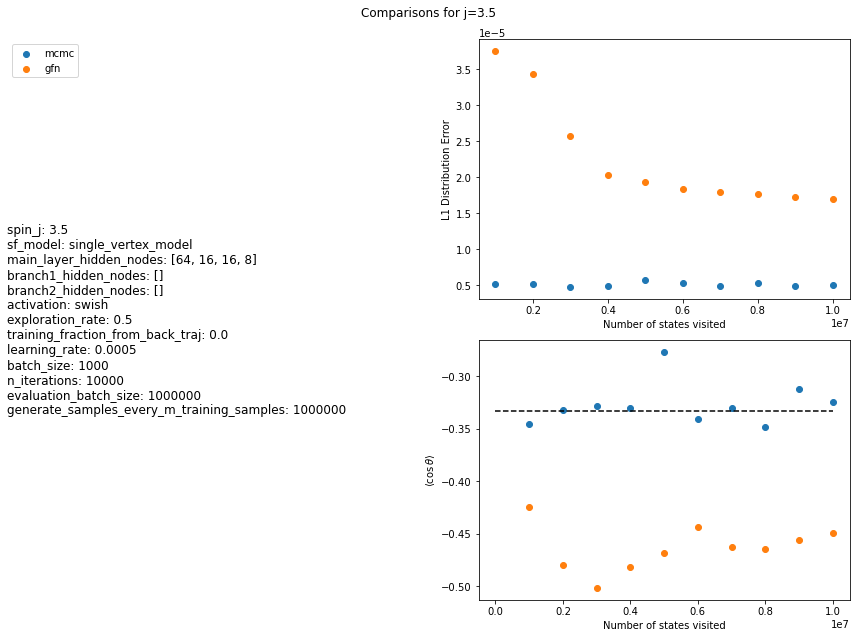

Running comparison for: model_9
Model number: 10 of 32 



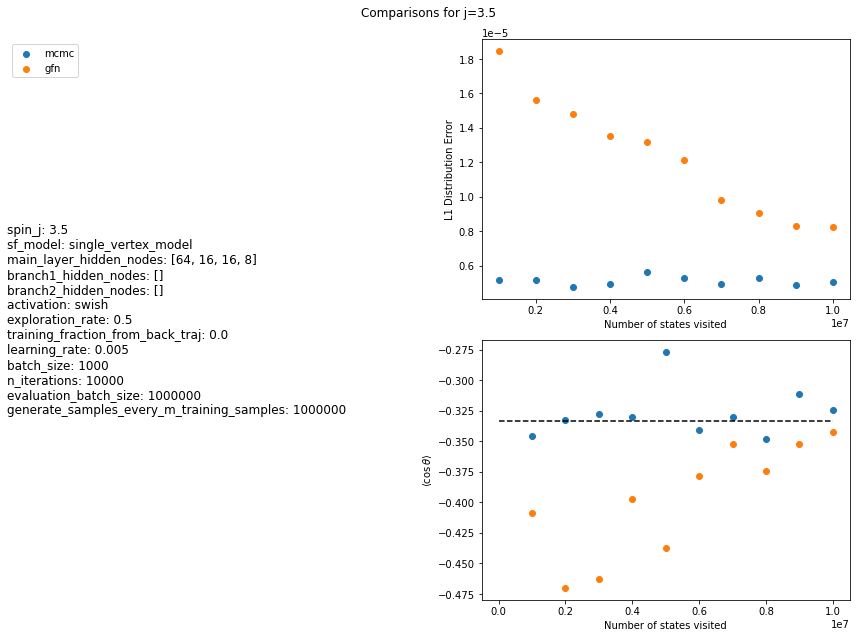

Running comparison for: model_10
Model number: 11 of 32 



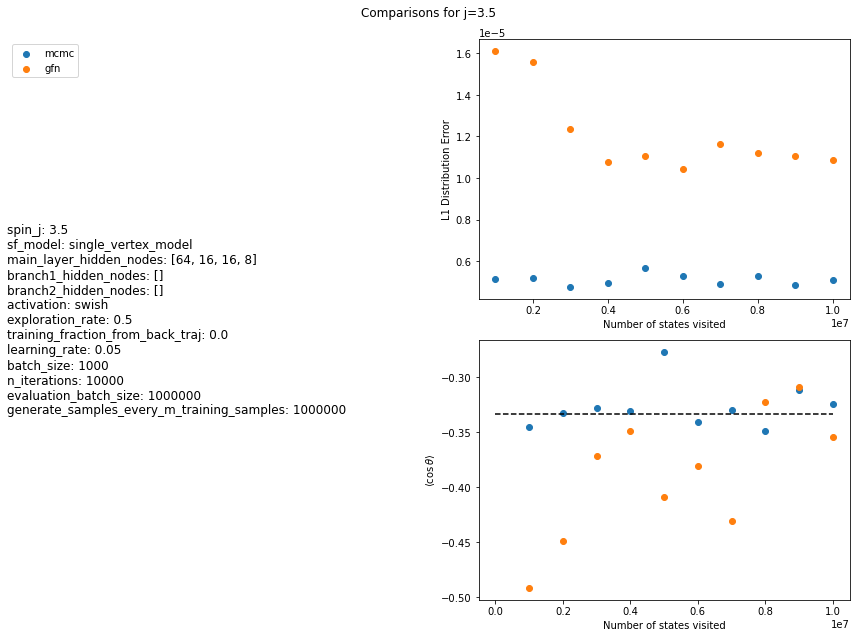

Running comparison for: model_11
Model number: 12 of 32 



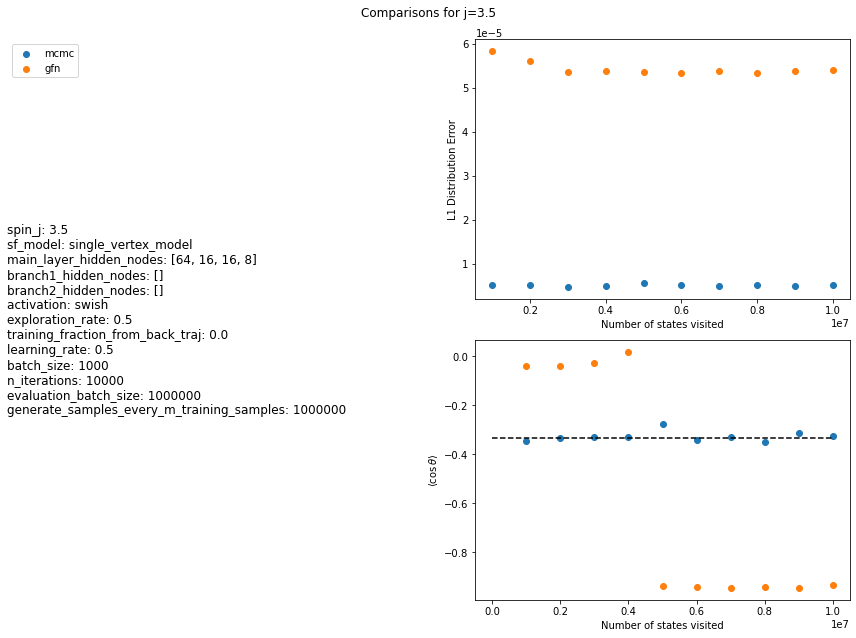

Running comparison for: model_12
Model number: 13 of 32 



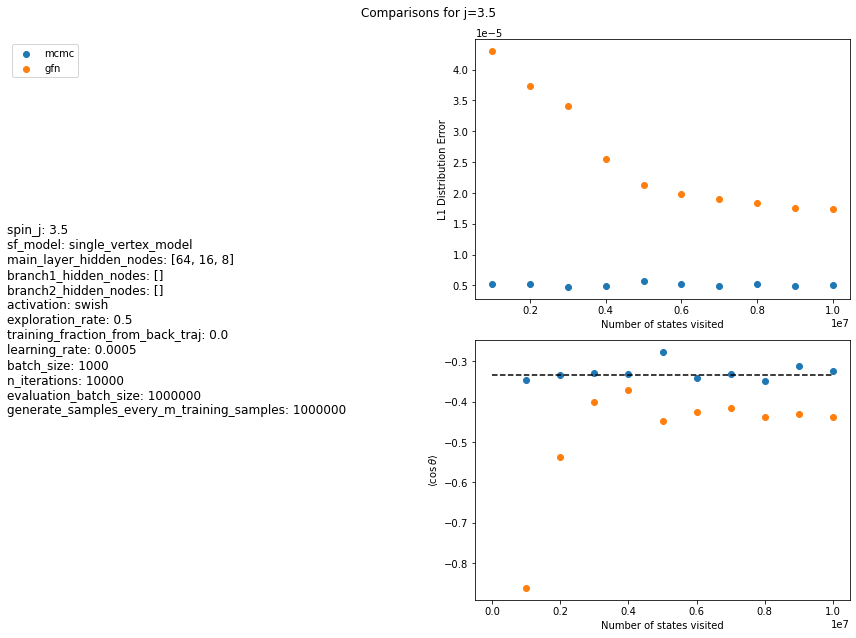

Running comparison for: model_13
Model number: 14 of 32 



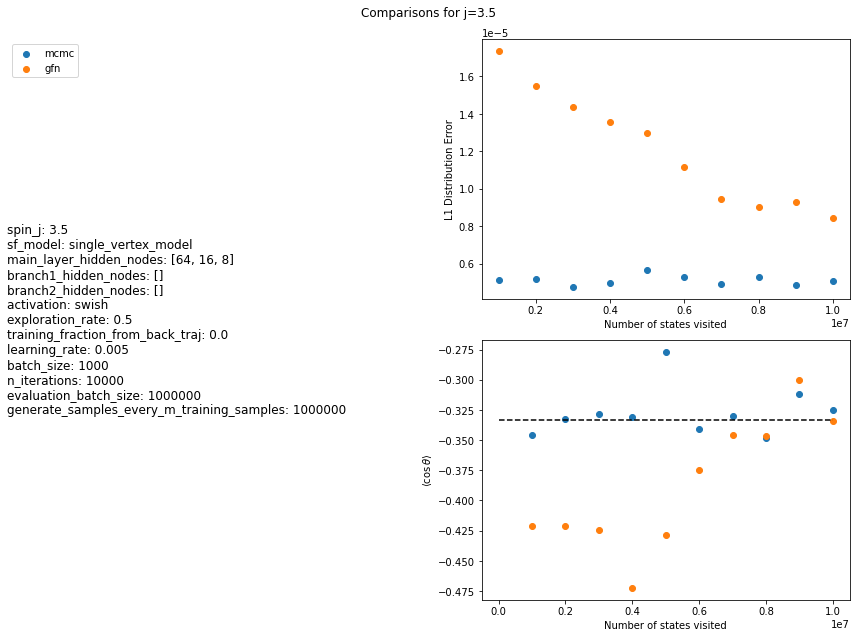

Running comparison for: model_14
Model number: 15 of 32 



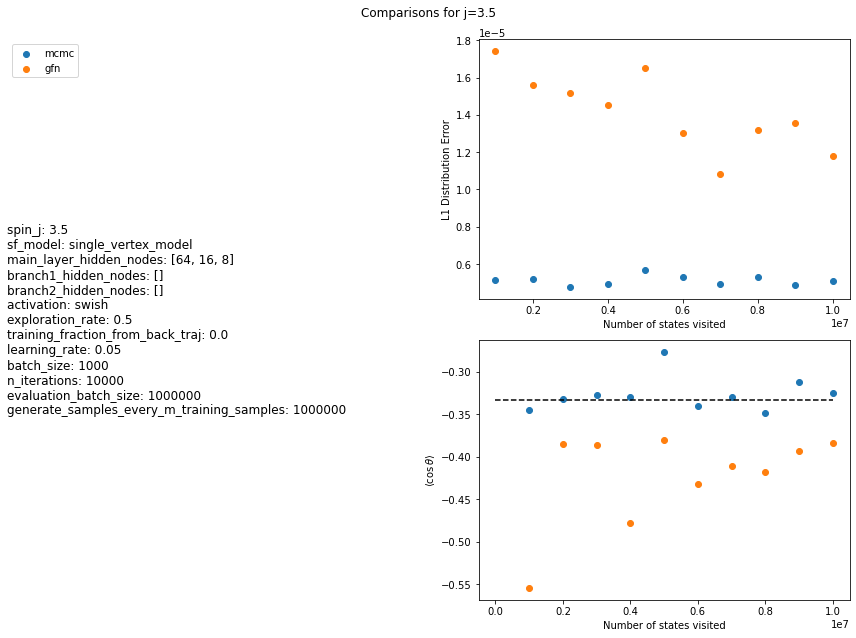

Running comparison for: model_15
Model number: 16 of 32 



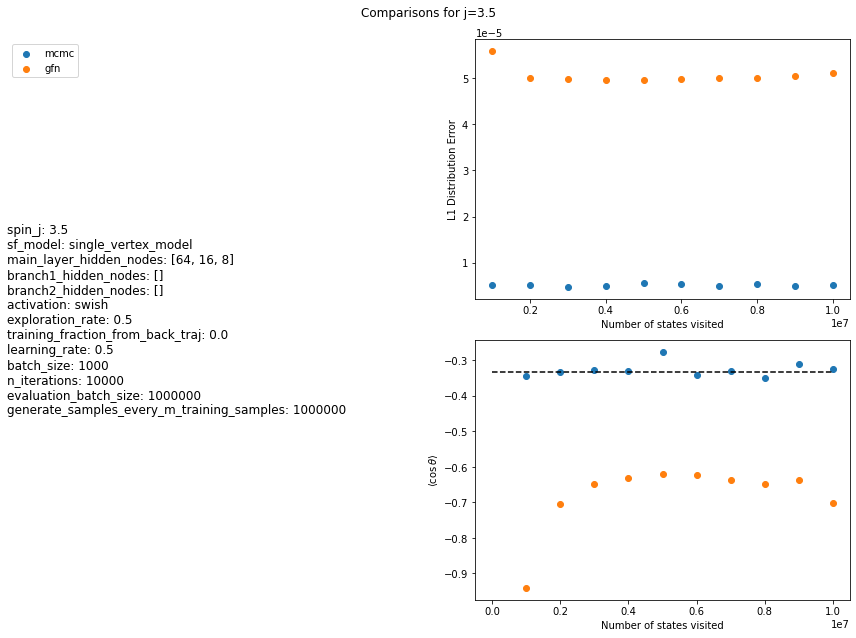

Running comparison for: model_16
Model number: 17 of 32 



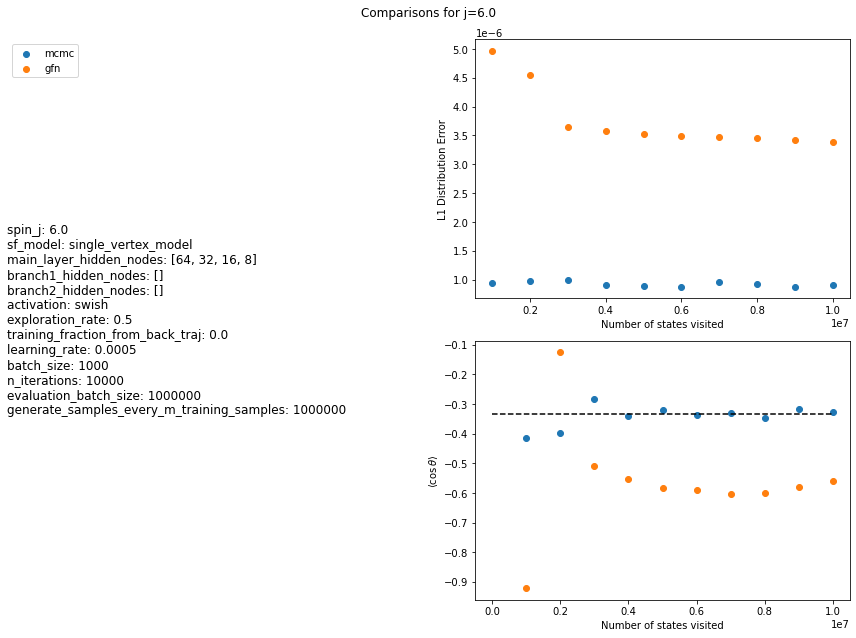

Running comparison for: model_17
Model number: 18 of 32 



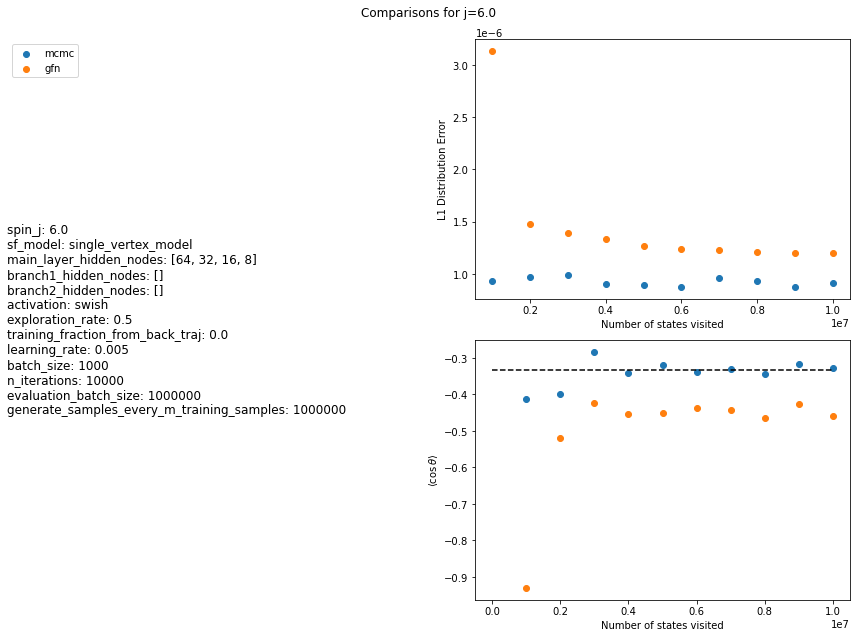

Running comparison for: model_18
Model number: 19 of 32 



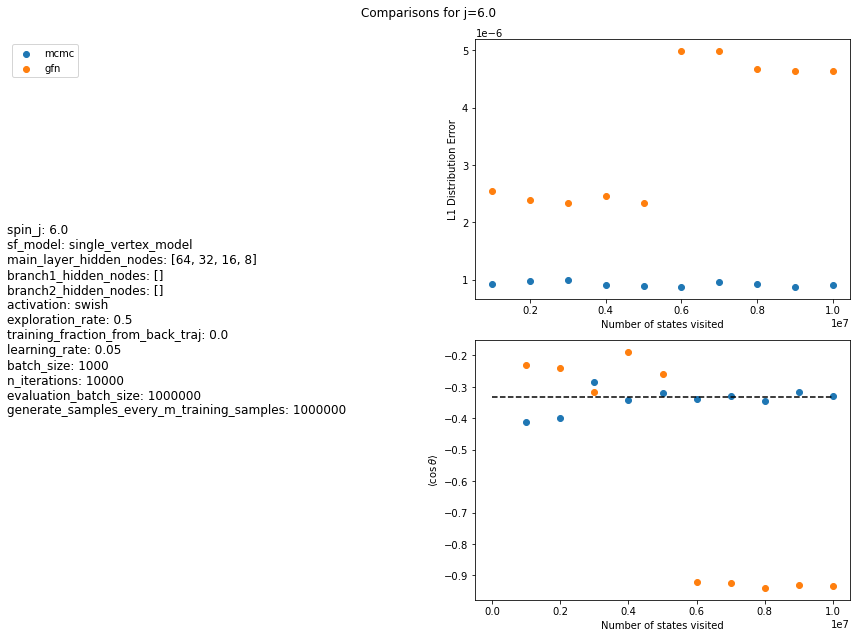

Running comparison for: model_19
Model number: 20 of 32 



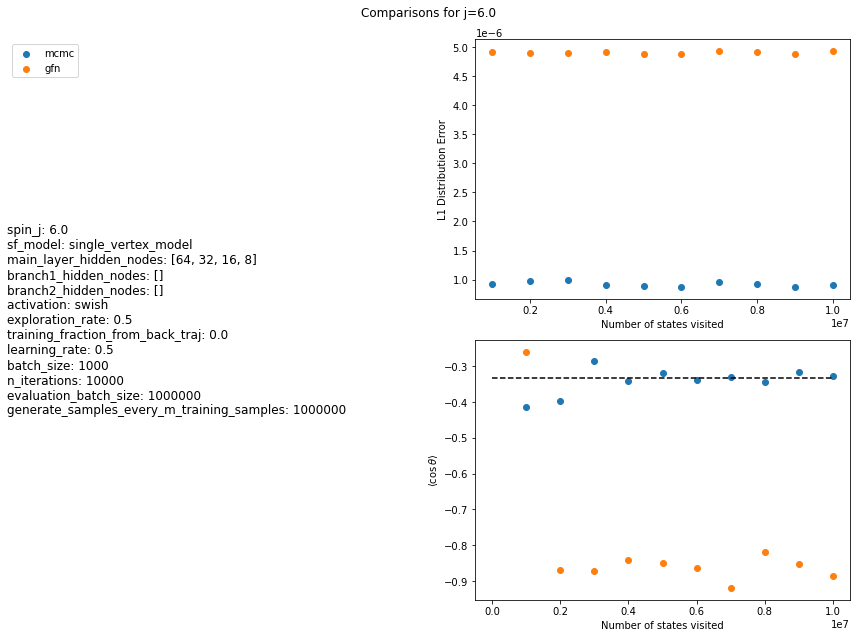

Running comparison for: model_20
Model number: 21 of 32 



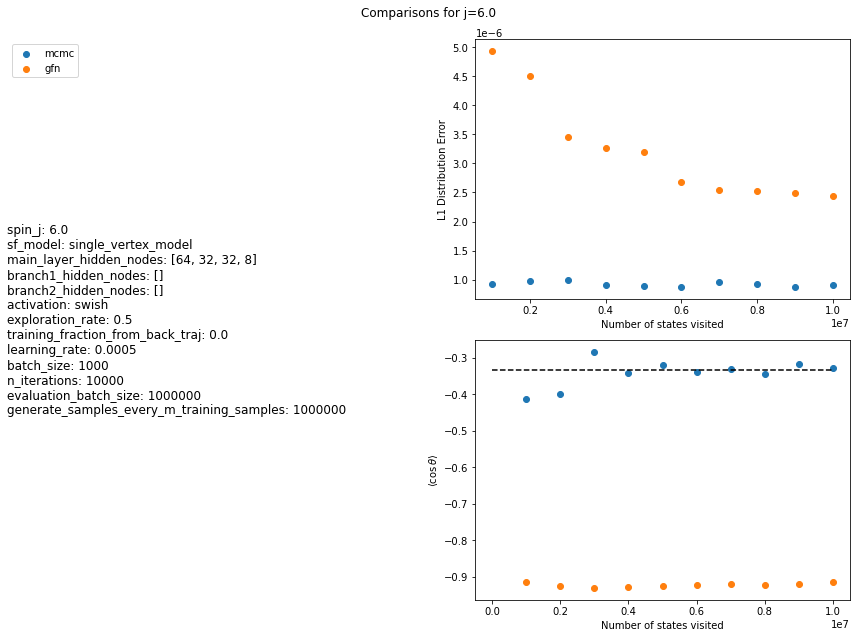

Running comparison for: model_21
Model number: 22 of 32 



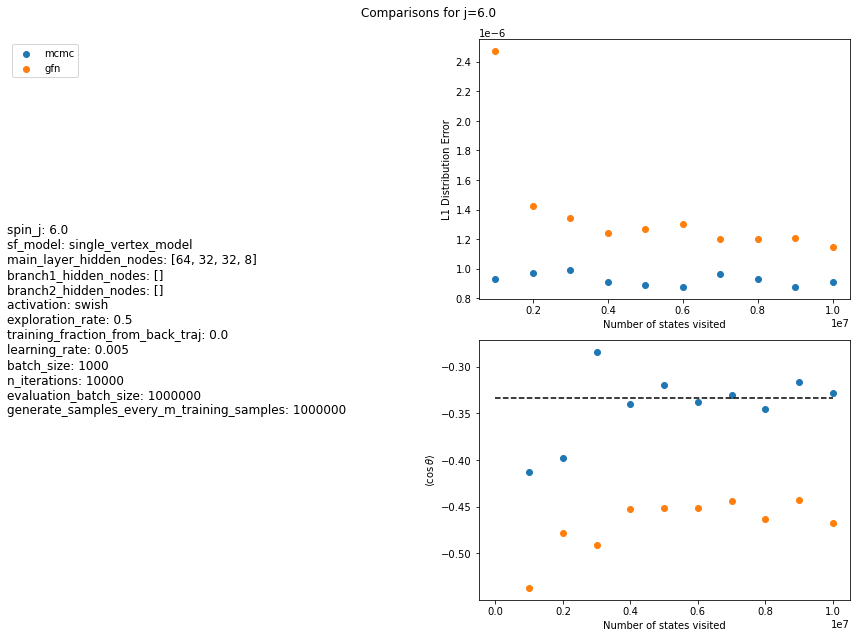

Running comparison for: model_22
Model number: 23 of 32 



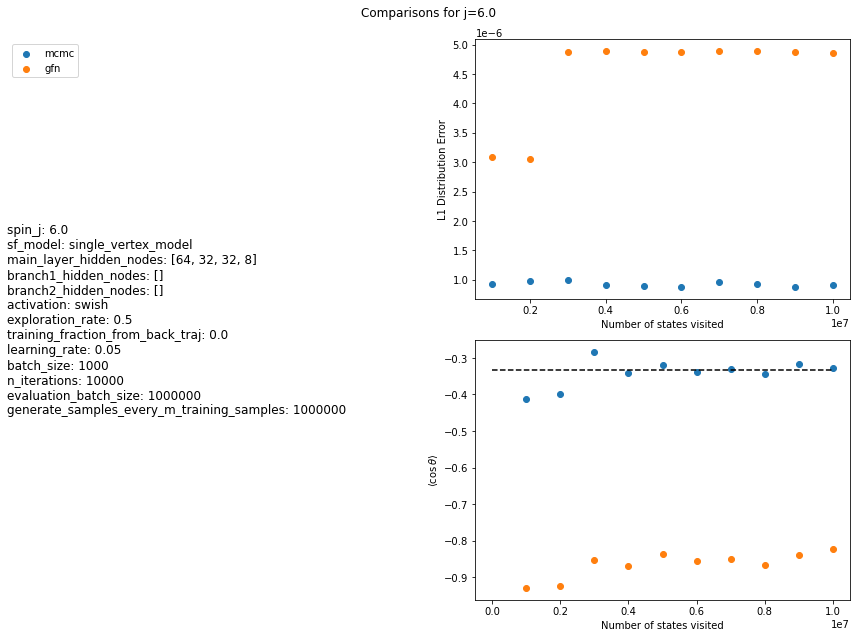

Running comparison for: model_23
Model number: 24 of 32 



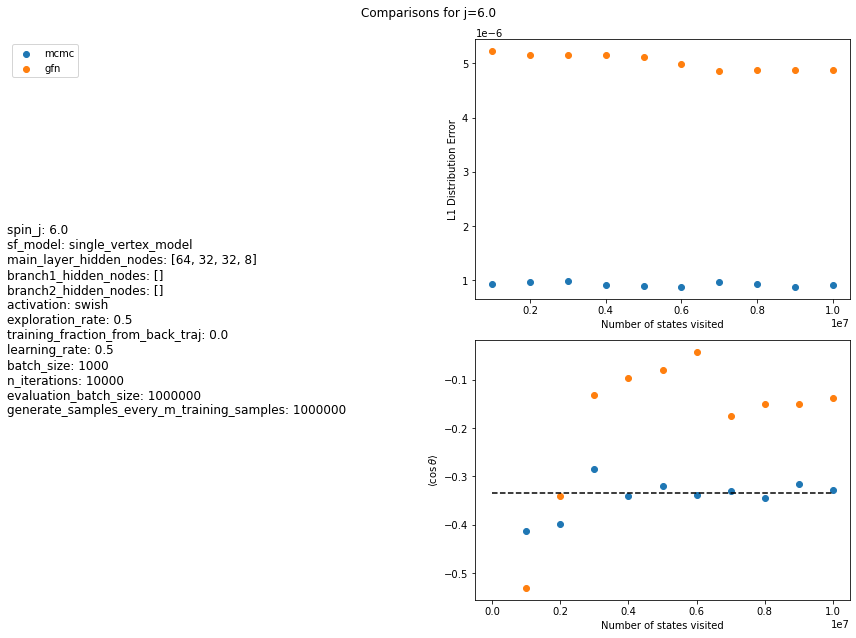

Running comparison for: model_24
Model number: 25 of 32 



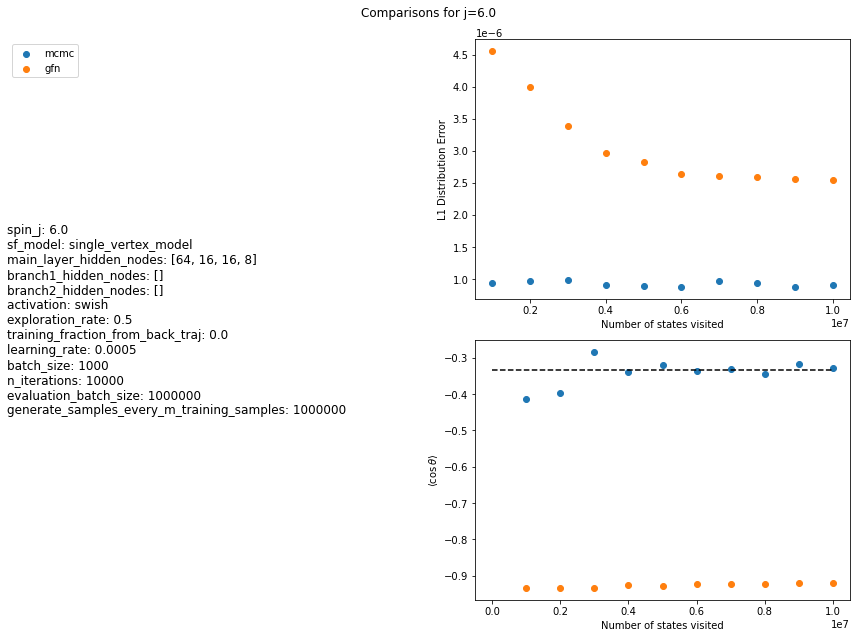

Running comparison for: model_25
Model number: 26 of 32 



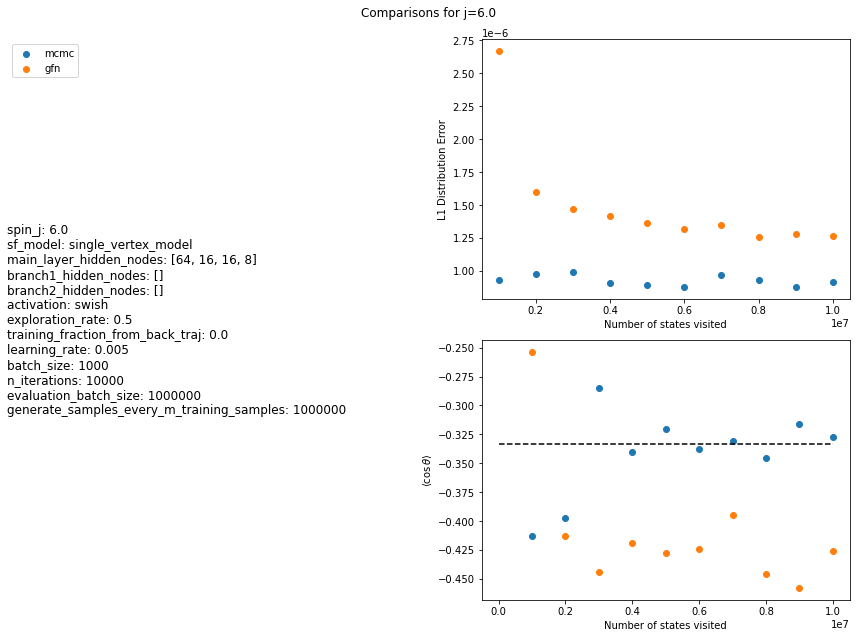

Running comparison for: model_26
Model number: 27 of 32 



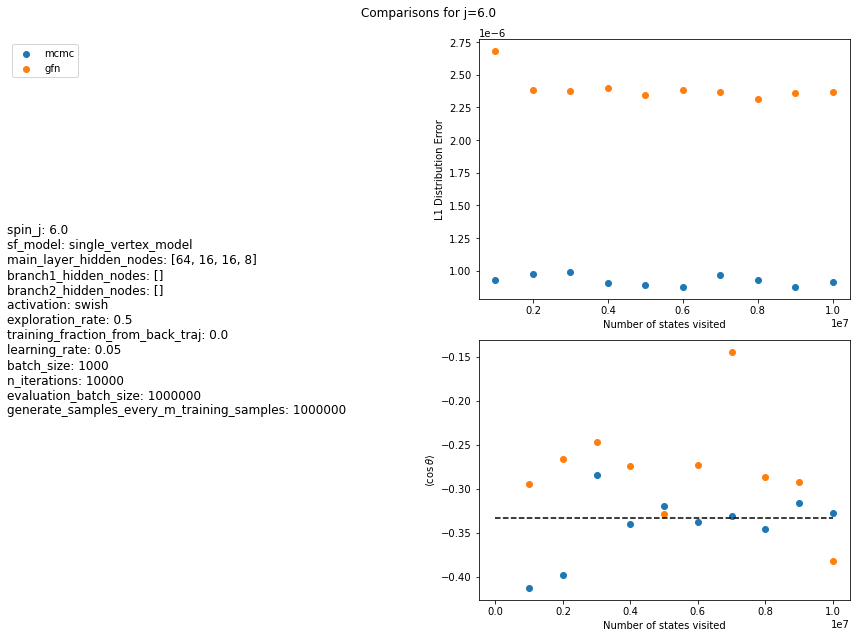

Running comparison for: model_27
Model number: 28 of 32 



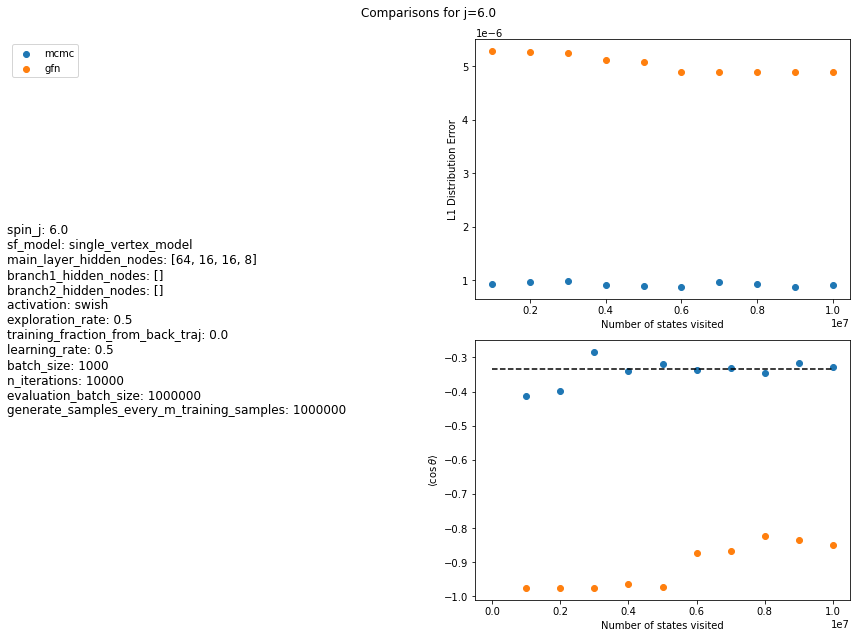

Running comparison for: model_28
Model number: 29 of 32 



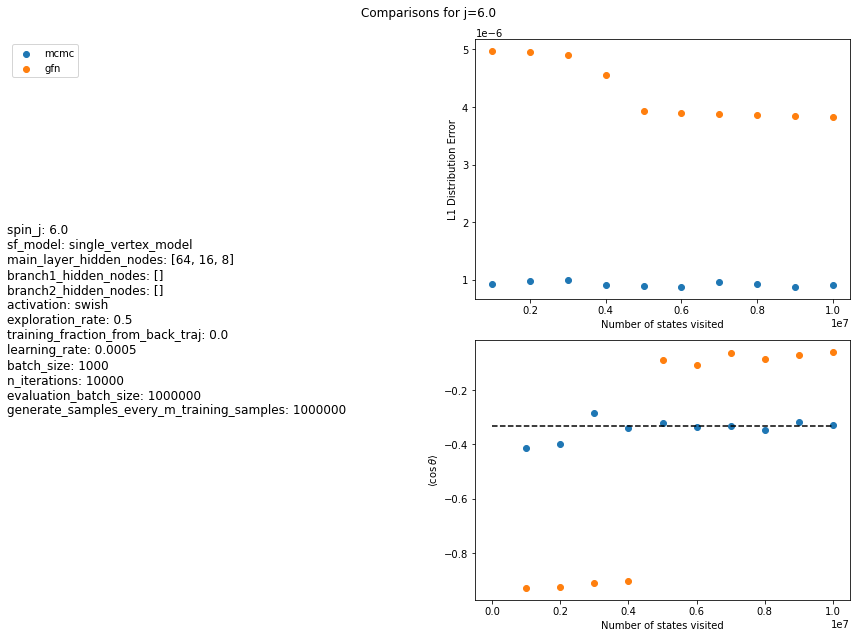

Running comparison for: model_29
Model number: 30 of 32 



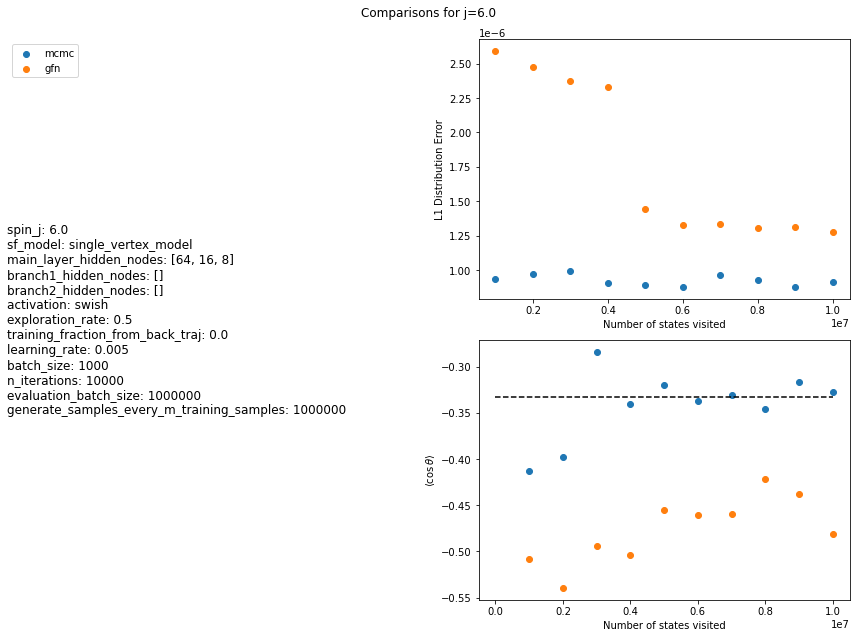

Running comparison for: model_30
Model number: 31 of 32 



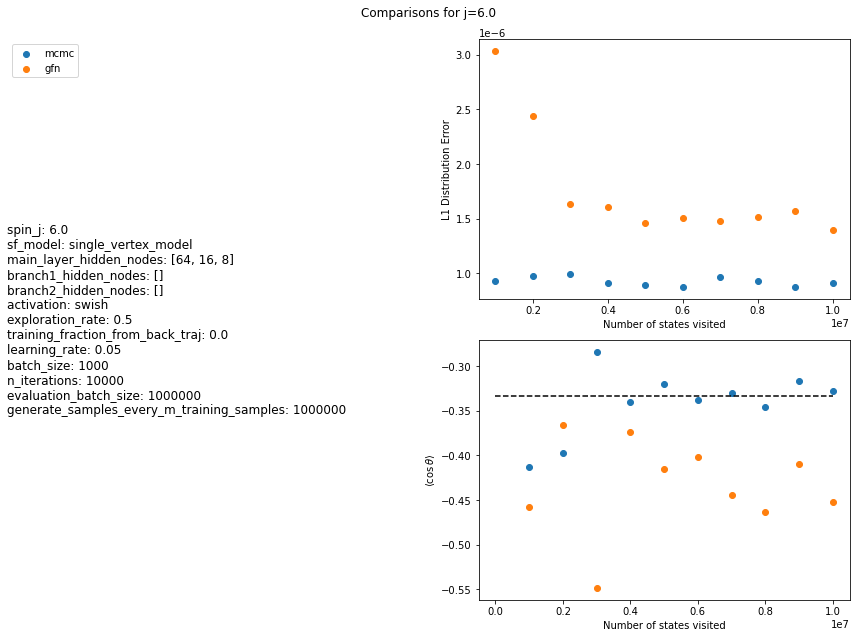

Running comparison for: model_31
Model number: 32 of 32 



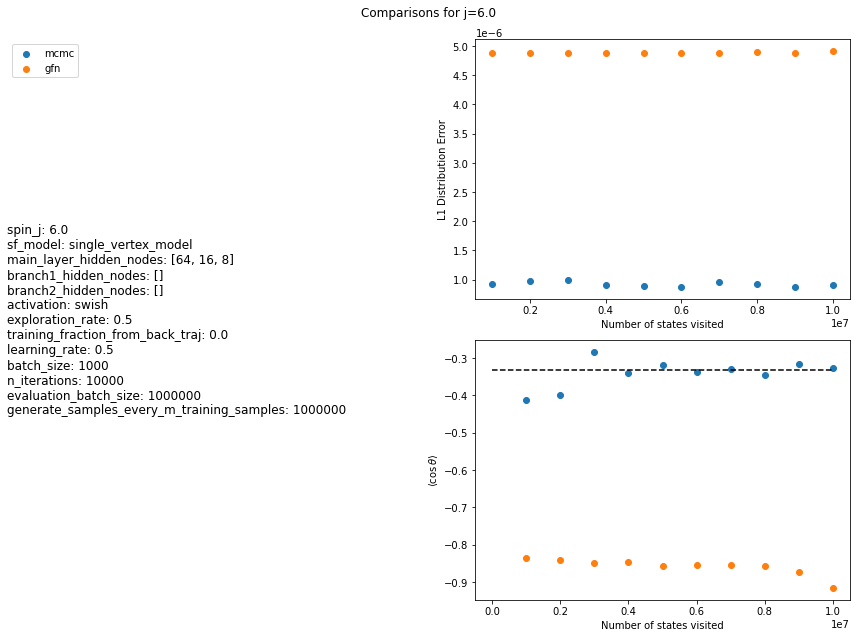

In [3]:
import json

spinfoams_dirs = models_dir.glob("*")

for spinfoam_dir in spinfoams_dirs:
    # Only do single vertex models for now, cannot compute empiral distributions for multi-vertex models
    if "star" in spinfoam_dir.name:
        break

    model_dirs = sorted(spinfoam_dir.glob("*"), key=lambda x: int(x.name.split("_")[-1]))
    for idx, model_dir in enumerate(model_dirs):
        print("Running comparison for:", model_dir.name)
        print("Model number:", idx + 1, "of", len(model_dirs), "\n")

        with open(Path(model_dir, "modelparams.json")) as f:
            parameters = json.load(f)
        spin = parameters["spin_j"]
        model_type = parameters["sf_model"]
        
        # print(list(root_dir.joinpath("data", "MCMC", model_type).glob(f"*/j_{float(spin)}/draws/draws_*.csv")))
        mcmc_files = sorted(
            root_dir.joinpath("data", "MCMC", model_type).glob(rf"*/j_{float(spin)}/draws/draws_*.csv"), 
            key=lambda x: int(x.name.split(".")[-2].split("_")[-1])
        )
        
        gfn_files = sorted(
            model_dir.glob(rf"generated_samples/*.feather"),
            key=lambda x: int(x.name.split(".")[-2].split("_")[-3])
        )
        
        vertex = np.load(
            root_dir.joinpath("data", "EPRL_vertices", "Python", "Dl_20", f"vertex_j_{float(spin)}.npz")
        )
        sq_amplitude = vertex**2
        expected_distribution = sq_amplitude / np.sum(sq_amplitude)
        
        mcmc_intertwiners = load_mcmc_intertwiners(mcmc_files)
        gfn_intertwiners = load_gfn_intertwiners(gfn_files)
        
        mcmc_l1_mean_errors = get_l1_distribution_error(mcmc_intertwiners, spin, expected_distribution)
        gfn_l1_mean_errors = get_l1_distribution_error(gfn_intertwiners, spin, expected_distribution)

        mean_obs_mcmc = calculate_mean_cosine_dihedral_angle(mcmc_intertwiners, spin)
        mean_obs_gfn = calculate_mean_cosine_dihedral_angle(gfn_intertwiners, spin)
        
        model_params = "\n".join(
            f"{k}: {v}" for k, v in parameters.items()
        )
        
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))
        error_ax, cos_ax = axs[0][1], axs[1][1]
        gs = axs[0][0].get_gridspec()
        for ax in axs[:, 0]:
            ax.remove()

        label_ax = fig.add_subplot(gs[:, 0])
        label_ax.axis("off")
        label_ax.text(0, 0.5, model_params, fontsize=12, verticalalignment='center')

        fig.suptitle(f"Comparisons for j={spin}")

        xs = [int((i+1)*1e6) for i in range(len(mcmc_files))]

        error_ax.scatter(xs, mcmc_l1_mean_errors, label="mcmc")
        error_ax.scatter(xs, gfn_l1_mean_errors, label="gfn")
        error_ax.set_ylabel("L1 Distribution Error")
        error_ax.set_xlabel("Number of states visited")

        cos_ax.scatter(xs, mean_obs_mcmc, label="mcmc")
        cos_ax.scatter(xs, mean_obs_gfn, label="gfn")
        cos_ax.hlines(-0.33333, 1, int(1e7), colors='k', linestyles='dashed')
        cos_ax.set_ylabel(r"$\langle \cos \theta \rangle$")
        cos_ax.set_xlabel("Number of states visited")

        label_ax.legend(*error_ax.get_legend_handles_labels(), loc="upper left")

        fig.tight_layout()
        filename = f"{model_type}_model_{idx}_comparison.png"
        fig.savefig(plots_dir.joinpath(filename))
        plt.show()